# AB Тестирование

Компания разработала новую веб-страницу, чтобы увеличить количество платящих пользователей за свой продукт. Они проводят тест AB, чтобы увидеть результаты этой новой страницы. Создаются две группы одинакового размера в качестве контрольной и экспериментальной группы, обозначенные A и B. Лечебной группе (B) представлена ​​новая веб-страница, а контрольной группе (A) — старая, и запускается эксперимент. Данные собираются для обеих групп, а затем применяется проверка гипотез, чтобы определить, является ли разница значительной или нет.

Шаги AB теста:
- Создание гипотезы: Новая страница увеличила количество платящих пользователей
- Проверка предположений
- Тестирование гипотезы
- Интерпретация результатов на основе значения p-value.

**Описание выборки**

```
user_id: Уникальный пользователь
timestamp: Время
group: тестовая и контрольная группа
landing_page: старая и новая страницы
converted: Статус регистрации после просмотра страницы (0-1)
```

H0: нет статистически значимой разницы между старой и новой страницей.

H1: существует статистически значимая разница между старой и новой страницей.

Если значение p меньше 0,05, оно считается значимым и будет использоваться непараметрический тест (критерий Манвитней). В противном случае параметрический тест (t-тест)

Гипотеза будет сделана на основе значения p, полученного в результате параметрического/непараметрического теста, который мы проведем. Этот результат ответит на вопрос: есть ли существенная разница между новой и старой страницей?

In [2]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 857.8 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 5.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 7.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("ab_data.csv")

## Исследование данных

In [6]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
df.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [10]:
print(df.shape)
df = df.drop_duplicates(subset= 'user_id', keep= False)
print(df.shape)

(294480, 5)
(286690, 5)


In [11]:
df.groupby(['group','landing_page']).agg({'landing_page': lambda x: x.value_counts()})

,,landing_page
group,landing_page,
control,old_page,143293
treatment,new_page,143397


In [12]:
df.groupby(['group','landing_page']).agg({'converted': 'mean'})

,,converted
group,landing_page,
control,old_page,0.120173
treatment,new_page,0.118726


In [13]:
pd.DataFrame(df.loc[:,'landing_page'].value_counts(normalize = True) * 100)

,proportion
landing_page,
new_page,50.018138
old_page,49.981862


In [14]:
df[((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) ]

,user_id,timestamp,group,landing_page,converted


## Тестирование

In [15]:
test_stat, pvalue = shapiro(df.loc[df["landing_page"] == "old_page", "converted"])
print("p-value:",pvalue)
print("test_stat:",test_stat)

p-value: 0.0
test_stat: 0.3792334198951721


In [16]:
test_stat, pvalue = shapiro(df.loc[df["landing_page"] == "new_page", "converted"])
print("p-value:",pvalue)
print("test_stat:",test_stat)

p-value: 0.0
test_stat: 0.37685757875442505


# Временные ряды

In [1]:
import pandas as pd

data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

df = pd.DataFrame(data)

# Преобразуем столбец 'Дата' в формат даты
df['Дата'] = pd.to_datetime(df['Дата'])

print(df)

        Дата  Продажи
0 2023-01-01     1000
1 2023-02-01     1200
2 2023-03-01     1300
3 2023-04-01     1100
4 2023-05-01     1400


In [2]:
subset = df[(df['Дата'] >= '2023-03-01') & (df['Дата'] <= '2023-04-30')]

print(subset)

        Дата  Продажи
2 2023-03-01     1300
3 2023-04-01     1100


Тесты на стационарность:

Первый шаг в анализе временных рядов — проверка стационарности. Для этого существует несколько статистических тестов. Один из них — тест Дики-Фуллера. Давайте применим его к нашему небольшому dataset с данными о продажах в условном филиалDNS

де

statsmodels — это пакет Python, который дополняет scipy для статистических вычислений, включая описательную статистику, а также оценку и вывод для статистических моделей.

In [7]:
%pip install statsmodels
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


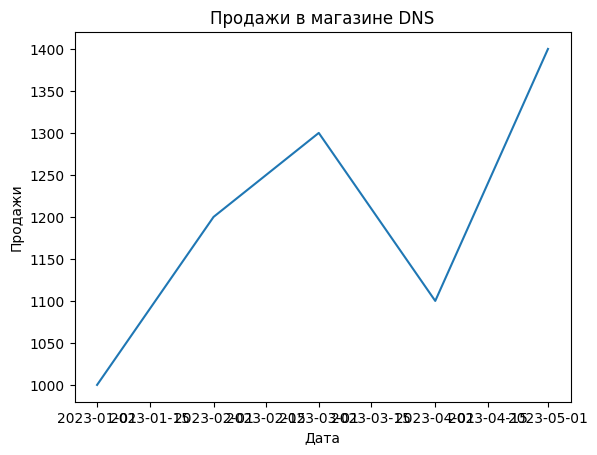

ADF Statistic: -2.160247
p-value: 0.220988
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Создаем dataset с данными о продажах
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

df = pd.DataFrame(data)

# Преобразуем столбец 'Дата' в формат даты
df['Дата'] = pd.to_datetime(df['Дата'])

# Построим график продаж
plt.plot(df['Дата'], df['Продажи'])
plt.title('Продажи в магазине DNS')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.show()

# Проведем тест Дики-Фуллера на стационарность
result = adfuller(df['Продажи'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

На выходе мы получим статистику теста Дики-Фуллера и p-значение. Если p-значение меньше уровня значимости (обычно 0.05), то мы можем отклонить нулевую гипотезу о нестационарности ряда и считать его стационарным.